<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/testing_01_kspace_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [0]:
%run "$PROJ_PATH/01_kspace_tfms.ipynb" # get the tfms to test

## Data

### MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [8]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [9]:
%time fn2attr = json.load(path_json)

CPU times: user 464 µs, sys: 927 µs, total: 1.39 ms
Wall time: 856 ms


In [0]:
fn2attr_items = L(i for i in fn2attr.items())

In [11]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

### Imagenette data

In [12]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [13]:
fn_test = fnames_net[0]
fn_test

Path('/root/.fastai/data/imagenette2-160/val/n03425413/n03425413_15601.JPEG')

## Real images

In [0]:
img = PILImageBW.create(fn_test)

In [0]:
# numpy computation

arr = apply(img, NpTfms.im2arr) # numpy arr
orig_shape = arr.shape # to reconstruct using conjugate symmetry

# using rfft
k             = apply(arr, NpTfms.real2k)
rev_img       = apply(k, NpTfms.k2real(orig_shape))

# using fft
fft_k         = apply(arr, NpTfms.fft_real2k)
fft_rev_img   = apply(fft_k, NpTfms.fft_k2real)

# Viz kspace
k_abs         = apply(k, NpTfms.np_abs)
k_log_abs     = apply(k, NpTfms.log_abs)

In [0]:
np.testing.assert_array_almost_equal(img, rev_img)
np.testing.assert_array_almost_equal(img, fft_rev_img)

In [0]:
# Pytorch tensor computation
onesided = True  # return half of array

t_arr = apply(img, TensorTfms.im2arr) # float tensor
orig_shape = t_arr.shape

# using rfft
t_k             = apply(t_arr, TensorTfms.real2k(onesided=onesided))
t_rev_img       = apply(t_k, TensorTfms.k2real(orig_shape, onesided=onesided))

# using fft - requires complex arr
fft_arr         = apply(t_arr, TensorTfms.real2complex)
t_fft_k         = apply(fft_arr, TensorTfms.fft_real2k)
t_fft_rev_img   = apply(t_fft_k, TensorTfms.fft_k2real)

# Viz kspace
t_k_abs         = apply(t_k, TensorTfms.t_abs)
t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

In [0]:
np.testing.assert_array_almost_equal(fft_arr, T.to_tensor(arr + 0j))

In [0]:
np.testing.assert_array_almost_equal(t_arr, t_rev_img)
np.testing.assert_array_almost_equal(t_arr, t_fft_rev_img)

In [0]:
# complex tensor to complex np - by default real/imaginary axes are (0,1)
def t2np(a, axes=(0,1)): return np.asarray(a[...,axes[0]]) + 1j * np.asarray(a[...,axes[1]])

# random complex numpy array
def rand_complex_arr(n_rows, n_cols):
  return np.random.rand(n_rows, n_cols) + 1j *  np.random.rand(n_rows, n_cols)

# test T.to_tensor & t2np are inverses
id = Pipeline([T.to_tensor, t2np])

In [0]:
random_arr = rand_complex_arr(5,5)
np.testing.assert_array_almost_equal(random_arr,id(random_arr))

In [0]:
np.testing.assert_array_almost_equal(k_abs, t_k_abs)

In [0]:
np.testing.assert_array_almost_equal(k, t2np(t_k, axes=(1,0))) # for some reason complex tensor i & j out of order

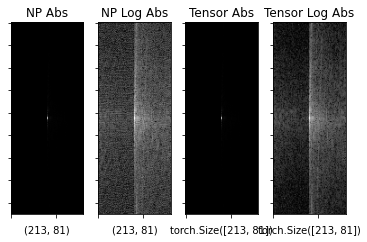

In [24]:
plot([k_abs, k_log_abs, t_k_abs, t_k_log_abs], ["NP Abs", "NP Log Abs", "Tensor Abs", "Tensor Log Abs"])

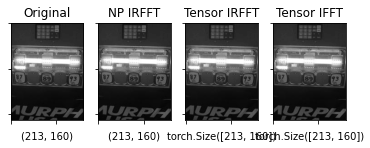

In [25]:
plot([img, rev_img, t_rev_img, t_fft_rev_img], ["Original", "NP IRFFT", "Tensor IRFFT", "Tensor IFFT"])

## MR images

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i):
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return kslice


In [0]:
kslices = KSliceTfm(fn2attr_items)

In [28]:
total_n_slices = kslices.total_n_slices
total_n_slices

1356

In [29]:
i = np.random.randint(0,total_n_slices)
i

1330

In [30]:
ck = kslices(i)
ck.shape, type(ck)

((640, 372), numpy.ndarray)

In [0]:
k_abs     = apply(ck, NpTfms.np_abs)
k_log_abs = apply(ck, NpTfms.log_abs)

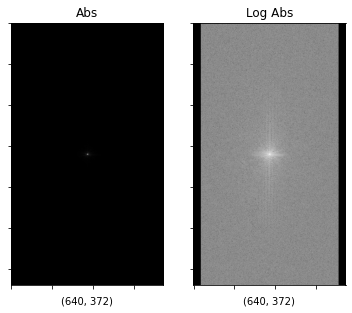

In [32]:
plot([k_abs, k_log_abs], ["Abs", "Log Abs"], ["gray", "gray_r"])

In [0]:
# numpy

complex_img  = apply(ck, NpTfms.k2complex)
img          = apply(complex_img, NpTfms.np_abs)

In [0]:
# pytorch

complex_img  = apply(ck, TensorTfms.k2complex)
t_img          = apply(complex_img, TensorTfms.t_abs)

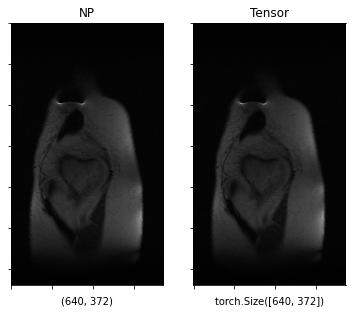

In [35]:
plot([img, t_img], ["NP", "Tensor"])

In [0]:
np.testing.assert_almost_equal(img, t_img, decimal=4) # max diff ~1e-4